# Latent/embedding space analysis

In this notebook we write methods to analyze the latent space created by a given embedding function. We'll first inspect one of the phase 1 embedding functions (i.e. trianed encoder network from a phase 1 autoencoder). We are concerned with measuring the "nextness" preserved in the embedding space. To that end, we the measurements we'll take on the embedded data set will generally revolve around measuring the distance between a pair of vectors at a time $t$ and the successive time $t+1$.

Also in this notebook we construct and analyze the Markov transition matrix formed by our data. To do this, we define a 100-dimensional statespace using k-means clustering (with k=100) and quantize our space based on each vector's closest k-means centroid. To measure the qualities of our Markov dynamics we look at the eigenspectrum of the transition matrix and the average log likelihood of our data under the Markov distribution and under a memoryless distribution that ignores the previous state.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [59]:
with open('../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy', 'rb') as f:
    spikes = np.load(f, allow_pickle=True)

In [60]:
spikes.shape

(487, 131, 2001)

1) Retrain our chosen embedding function

*We will retrain and use our 3-layer FFW autoencoder model with $\tau=0$, bottleneck dimension of 10, and bce weight of 100:*

***Loading these necessary classes/methods in from our experimentation files***

In [61]:
import sys  
sys.path.insert(0, '../pytorch_experiments')

# importing necessary modules from our experimentation files
from create_dataloaders import get_binary_dataloader
from models import FFW_Autoencoder, FFW_Autoencoder_v2, FFW_Autoencoder_v3, train
from experiments import run_experiment

In [62]:
dp = '../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy'
m = 10
w = 100
tau = 0
epochs = 5

model, output = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)

[1,  1000] loss: 0.439
[1,  2000] loss: 0.225
[1,  3000] loss: 0.170
[1,  4000] loss: 0.136
[1,  5000] loss: 0.118
[1,  6000] loss: 0.105
[1,  7000] loss: 0.097
[1,  8000] loss: 0.088
[1,  9000] loss: 0.082
[2,  1000] loss: 0.076
[2,  2000] loss: 0.073
[2,  3000] loss: 0.068
[2,  4000] loss: 0.067
[2,  5000] loss: 0.065
[2,  6000] loss: 0.062
[2,  7000] loss: 0.060
[2,  8000] loss: 0.058
[2,  9000] loss: 0.059
[3,  1000] loss: 0.053
[3,  2000] loss: 0.052
[3,  3000] loss: 0.054
[3,  4000] loss: 0.050
[3,  5000] loss: 0.049
[3,  6000] loss: 0.049
[3,  7000] loss: 0.049
[3,  8000] loss: 0.048
[3,  9000] loss: 0.046
[4,  1000] loss: 0.046
[4,  2000] loss: 0.045
[4,  3000] loss: 0.044
[4,  4000] loss: 0.044
[4,  5000] loss: 0.044
[4,  6000] loss: 0.043
[4,  7000] loss: 0.044
[4,  8000] loss: 0.043
[4,  9000] loss: 0.043
[5,  1000] loss: 0.041
[5,  2000] loss: 0.042
[5,  3000] loss: 0.040
[5,  4000] loss: 0.041
[5,  5000] loss: 0.041
[5,  6000] loss: 0.039
[5,  7000] loss: 0.041
[5,  8000] 

In [63]:
from experiments import calculate_avg_pred_prob

nospike_pred_prob, spike_pred_prob = calculate_avg_pred_prob(model, torch.from_numpy(spikes).float(), tau)
print('model avg. probability for no input spike',str(nospike_pred_prob),str(type(nospike_pred_prob)))
print('model avg. probability for input spike',str(spike_pred_prob),str(type(spike_pred_prob)))

model avg. probability for no input spike 0.02574753761291504 <class 'float'>
model avg. probability for input spike 0.9866267442703247 <class 'float'>


2) Get our embedded data set

*Grabbing the part of our model evaluation function that does this*

In [64]:
def get_embedded_dataset(np_data, model, M, tau):
    '''
    Function to get embedded dataset. This is a modification of the part of our model
    assessment function that gets a reconstructed output of our input dataset. In this version
    we don't pass the original data through our entire autoencoder, but just the encoder portion,
    thus creating our embedded dataset.
    
    We assume the data is given to the method as a numpy array, so we cast it to a tensor
    '''
    data = torch.from_numpy(np_data).float()
    
    num_trials = data.shape[0]
    num_units = M
    num_recon_samples = data.shape[2] - 2*tau
    embedded_input = torch.from_numpy((np.zeros((num_trials, M, num_recon_samples)))).float()

    # the loop to get the reconstructed outputs and populate the output array
    for trial in range(num_trials):
        for ind in range(num_recon_samples):
            # we get our indexing logic from our dataset object
            input_sample = data[trial,:,ind:ind+2*tau+1]
            # ... and we want to squeeze out the 1-dimension in the case that tau=0
            single_sample_batch = torch.squeeze(input_sample)

            with torch.no_grad(): 
                sample_recon = model.forward(single_sample_batch)
            
            embedded_input[trial,:,ind] = sample_recon

            
    # have to use separate delete statements for the two margins we want to take off
    # (looks like you can't do lists of intervals this way)
    if tau > 0:
        trimmed_input = np.delete(data, np.s_[:tau],axis=2)
        trimmed_input = np.delete(trimmed_input, np.s_[-tau:],axis=2)
    else:
        trimmed_input = data

    return trimmed_input, embedded_input

2a) Get our encoder network from our full trained model

In [65]:
encoder = model.encoder

In [66]:
encoder

Sequential(
  (0): Linear(in_features=131, out_features=90, bias=True)
  (1): Tanh()
  (2): Linear(in_features=90, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=10, bias=True)
)

***NB: The encoder ends in a linear layer without a non-linearity because the non-linearity is applied to the output of the encoder in the forward pass method. Here we leave the last Tanh off and define our embedding space pre-nonlinearity in order to leave as much data in tact as possible (without squashing the data into -1,1)***

2b) Feed our spike data through it

In [67]:
input_spikes, embedded_spikes = get_embedded_dataset(spikes, encoder, M=10, tau=0)

In [68]:
print(input_spikes.shape)
print(embedded_spikes.shape)

torch.Size([487, 131, 2001])
torch.Size([487, 10, 2001])


### Plotting vector pair distance at time $t$ versus at time $t+1$

3a) For a given threshold $p$, want to get the $p\%$ closest vectors, across all trials and time samples

*From this we want a set of close vector pairs, and for a given pair we'll look at the pair comprising both vectors' next step and compare the distance between the next step vectors to the distance between the pre-step vectors.*


***Resolution: In order to have a more reasonable number of vectors to compars, while also possibly making a comparison that makes more sense in terms of dynamics, we'll just compute this within a the group of vectors found at a given $t$ across our 487 trials***


In [66]:
# we'll use scipy to give us our high-dimensional Euclidean distance calculator
from scipy.spatial import distance

emb1, emb2, emb3 = embedded_spikes[0,:,0], embedded_spikes[0,:,1], embedded_spikes[0,:,2]
print(distance.euclidean(emb1, emb2))
print(distance.euclidean(emb1, emb3))

4.156966686248779
5.898542404174805


*NB: we're going to get a large number of pairs with a distance of 0 coming from the relatively high occurence of the zero vector; when choosing a proportion will want to make sure we're getting a significant number of pairs that aren't tuples of the zero vector.*

In [151]:
def get_closest_proportion_of_vectors(data, proportion, t):
    '''
    For a given time t, we'll look at the 487 vectors present at that time
    across all of our trials and return the p% closest vector pairs.
    
    Going to setup a 487x487 matrix where the i,j entry will give the distance
    between vector i and j.
    
    We'll get the vector pairs from the coords of the set of smallest values
    (excluding the diagonal entries).
    
    We'll return pairs of tuples of the form ((i, j), (t, pair distance at t))
    in order to store all relevant information for our comparison in a single place
    '''
    num_trials = data.shape[0]
    dists = np.zeros((num_trials, num_trials))
    vects = data[:, :, t]
    
    for i in range(num_trials):
        for j in range(num_trials):
            if i != j:
                vi, vj = vects[i], vects[j]
                dists[i,j] = distance.euclidean(vi, vj)
                
    # get our threshold value for the p% smallest inter-vector distances
    sorted_dists = np.sort(dists.flatten())
    # --> there are 19231 pairs that have a distance of 0, so we can't get
    # --> a proportion smaller than 8.1%
    threshold = sorted_dists[int(proportion*len(sorted_dists)) - 1]
    
    # we'll go back through our matrix and store all of the vector pairs that
    # are below our distance threshold
    close_vects = []
    for i in range(num_trials):
        for j in range(num_trials):
            if dists[i,j] <= threshold:
                close_vects.append(((i,j), (t, dists[i,j])))
                
    return close_vects

In [98]:
close_vectors = get_closest_proportion_of_vectors(embedded_spikes, 0.1, 100)

[ 0.          0.          0.         ... 10.94081593 11.05346489
 11.05346489]
3.819847583770752


In [99]:
len(close_vectors)

24171

In [101]:
# and if we want to get rid of all the overlapping points we can strip them out like this
non_overlapping_vectors = [(coords, time_dist) for (coords, time_dist) in close_vectors if time_dist[1] > 0]

In [103]:
len(non_overlapping_vectors)

4940

3b) For a given list of close vectors, get the list of distances of those vector pairs at the next time step

In [106]:
def get_next_step_distances(close_vectors, data):
    '''
    Calculate the list of distances at t+1 for a list of vectors at time t.
    Data given in the form ((i,j), (t, dists[i,j])).
    
    Return an analogous list to the input one
    '''
    next_step_vects = []
    for ((i,j), (t, _)) in close_vectors:
        vi, vj = data[i, :, t+1], data[j, :, t+1]
        dist = distance.euclidean(vi, vj)
        next_step_vects.append(((i,j), (t+1, dist)))
        
    return next_step_vects

In [107]:
next_step_vs = get_next_step_distances(non_overlapping_vectors, embedded_spikes)

In [109]:
len(next_step_vs)

4940

3c) Process the vector distance lists from above to get lists of (dist_at_t) and (dist_at_t+1)

In [122]:
next_step_vs[0][1][1]

8.356573104858398

In [123]:
vect_step_dists = [[],[]]
for i in range(len(non_overlapping_vectors)):
    vect_step_dists[0].append(non_overlapping_vectors[i][1][1])
    vect_step_dists[1].append(next_step_vs[i][1][1])

3d) Plotting dist at t versus dist at t+1

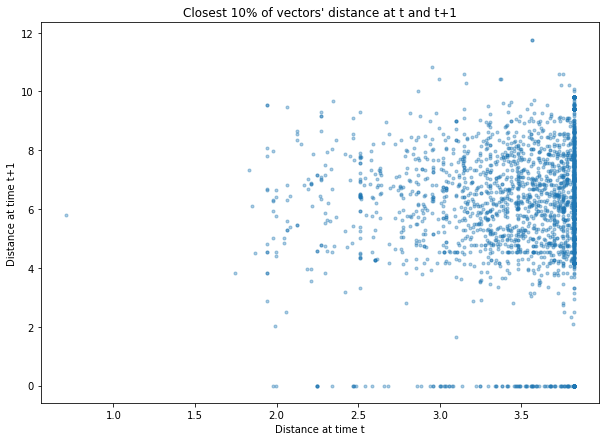

In [133]:
plt.figure(figsize = (10,7))
plt.scatter(x=vect_step_dists[0], y=vect_step_dists[1], marker='.', alpha=0.2)
plt.xlabel('Distance at time t')
plt.ylabel('Distance at time t+1')
plt.title('Closest 10% of vectors\' distance at t and t+1')
plt.show()

4) Wrapping the above into a method that takes in a dataset, t, and proportion value

In [139]:
def plot_vect_step_dist(data, t, proportion, remove_overlapping=False):
    '''
    Function to generate a plot like the one above for any given dataset,
    time t, and proportion of closest vector pairs
    '''
    # 1) get the closest vector pairs
    close_vectors_t = get_closest_proportion_of_vectors(data, proportion, t)
    
    # 2) if we want to remove the overlapping points (those pairs with a distance of zero)
    # from this group then we can turn the 'remove_overlapping' flag to True
    if remove_overlapping:
        close_vectors_t = [(coords, time_dist) for (coords, time_dist)\
                                in close_vectors_t if time_dist[1] > 0]
        
    # 3) get the next step distances for our list of vector pairs
    close_vectors_tplus1 = get_next_step_distances(close_vectors_t, data)
    
    # 4) get our list of x and y coords for the points we'll plot
    vect_step_dists = [[],[]]
    for i in range(len(close_vectors_t)):
        vect_step_dists[0].append(close_vectors_t[i][1][1])
        vect_step_dists[1].append(close_vectors_tplus1[i][1][1])
        
    # 5) plot
    plt.figure(figsize = (10,7))
    plt.scatter(x=vect_step_dists[0], y=vect_step_dists[1], marker='.', alpha=0.2)
    plt.xlabel(f'Distance at time t={str(t)}')
    plt.ylabel(f'Distance at time t+1={str(t+1)}')
    plt.title(f'Closest {proportion*100}% of vectors\' distance at t={str(t)} and t+1={str(t+1)}')
    plt.show()
    
    # 6) ... and also return the vector pair lists in case we want those
    return close_vectors_t, close_vectors_tplus1

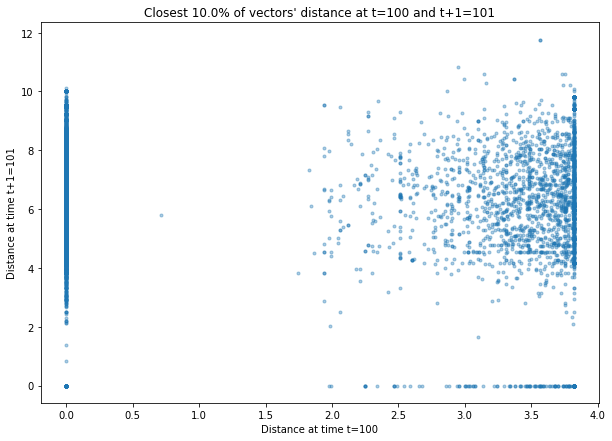

In [142]:
_ = plot_vect_step_dist(embedded_spikes, t=100, proportion=0.1, remove_overlapping=False)

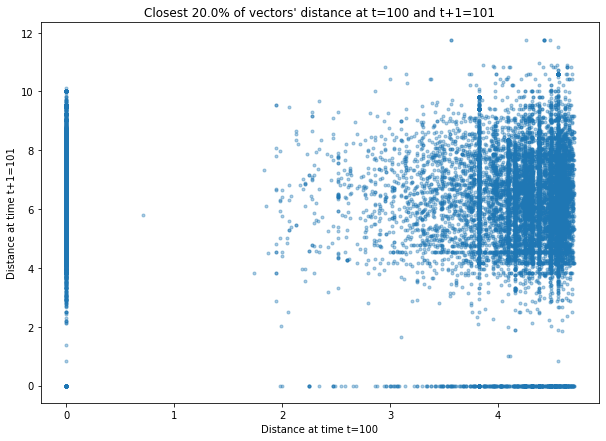

In [145]:
_ = plot_vect_step_dist(embedded_spikes, t=100, proportion=0.2, remove_overlapping=False)

### Plotting percentile of pair closeness against ratio of $t+1$ distance to $t$ distance

In [156]:
def plot_closeness_ratio_against_percentile(data, t):
    '''
    Function to plot percentile of pair closeness versus (pair dist. @ t)/(pair dist. @ t+1).
    For the sake of managing computational load we'll limit this to considering the pairs
    of vectors associated with a specific t/t+1 combination, which gives us p% of 237,000 points
    for each threshold value.
    '''
    percentiles = [0.1,0.2,0.3,
                   0.4,0.5,0.6,
                   0.7,0.8,0.9,1.0]
    
    # list of percentiles 
    plotting_coords = [[],[]]
    
    for p in percentiles:
        # for a given threshold we calculate the average t+1/t distance over all points
        # ---> going to copy some of the process from the other plotting function
        close_vectors_t = get_closest_proportion_of_vectors(data, p, t)

        # need to remove overlapping points from this list to prevent division by zero in the ratio
        close_vectors_t = [(coords, time_dist) for (coords, time_dist)\
                                in close_vectors_t if time_dist[1] > 0]

        close_vectors_tplus1 = get_next_step_distances(close_vectors_t, data)
        
        vect_dist_ratios = []
        for i in range(len(close_vectors_t)):
            d_t = close_vectors_t[i][1][1]
            d_tplus1 = close_vectors_tplus1[i][1][1]
            step_ratio = d_tplus1/d_t
            vect_dist_ratios.append(step_ratio)
            
        plotting_coords[0].append(p)
        plotting_coords[1].append(np.mean(vect_dist_ratios))
        
    plt.figure(figsize = (10,7))
    plt.plot(plotting_coords[0], plotting_coords[1], linestyle='--', marker='+')
    plt.xlabel('Proportion of vectors considered')
    plt.ylabel(f'Ratio of distances at t+1={str(t+1)} and t={str(t)}')
    plt.title('Vector pair distance ratio versus proportion of vectors considered')
    plt.show()

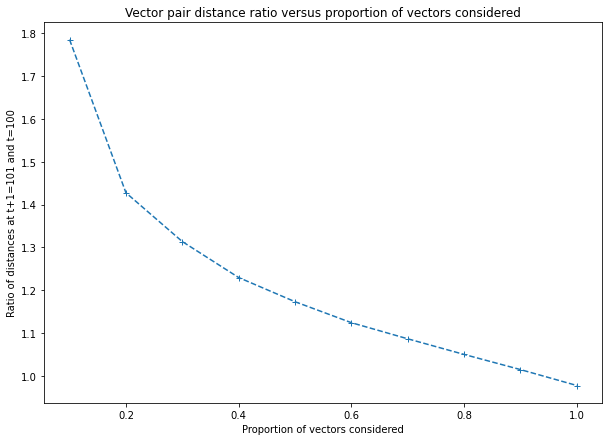

In [161]:
plot_closeness_ratio_against_percentile(embedded_spikes, t=100)

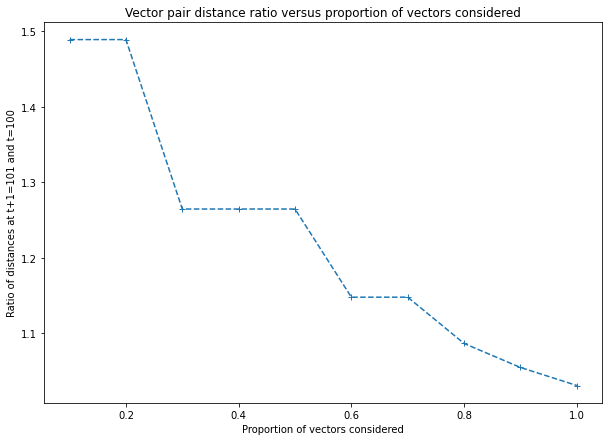

In [162]:
plot_closeness_ratio_against_percentile(spikes, t=100)

## Calculating the empirical transition matrix

What kinds of ranges do we see in the ten different axes of our embedded space?

In [166]:
for i in range(10):
    print(f'Range of dimension {i}: {min(torch.flatten(embedded_spikes[:,i,:]))} to {max(torch.flatten(embedded_spikes[:,i,:]))}')

Range of dimension 0: -2.865330696105957 to 2.358306646347046
Range of dimension 1: -2.419790506362915 to 2.907783269882202
Range of dimension 2: -1.7546768188476562 to 2.6418850421905518
Range of dimension 3: -2.3718788623809814 to 2.7822258472442627
Range of dimension 4: -2.8727214336395264 to 2.7837870121002197
Range of dimension 5: -3.051497220993042 to 2.6640889644622803
Range of dimension 6: -1.6960222721099854 to 2.51393723487854
Range of dimension 7: -2.522404432296753 to 1.5506179332733154
Range of dimension 8: -2.5679752826690674 to 2.928347587585449
Range of dimension 9: -2.897836208343506 to 2.5652360916137695


***With an embedding space that's 10-dimensional, I'm not sure how we can scalar quantize our space to get good data resolution on our space without creating a humongous number of possible states (i.e. 10 bins per dimension is 10 billion states)***

Going to use k means clustering to get the 100 centroids that are found in the set of *unique* vectors from our data. (We'll base the centroids on the distinct elements of our dataset to get a geometric picture rather than occurrence-weighted picture; I figured that's the right decision because the binning approach would have been ignorant to frequency as well, but this could be changed by calling k-means on the non-unique set of vectors).

**1) Want to reshape the data into `(trials x sequence length, data dim)` form so we can give the k means algorithm a list of vectors** 

In [184]:
embedded_vects = np.transpose(embedded_spikes, (0,2,1))
# also casting to np array in case that's more compatible with scipy
embedded_vects = np.array(np.reshape(embedded_vects, (487*2001, 10)))
print(embedded_vects.shape)

(974487, 10)


In [218]:
from scipy.cluster.vq import vq, kmeans, whiten

In [198]:
#getting the unique embedded vectors
unique_emb_vects = np.unique(embedded_vects,axis=0)

In [199]:
unique_emb_vects.shape

(113883, 10)

In [215]:
codebook, distortion = kmeans(unique_emb_vects, 100, iter=100)

In [216]:
codebook.shape

(100, 10)

*Did this kmeans algorithm work? Let's look at a couple dimensions of the centroids among the data:*

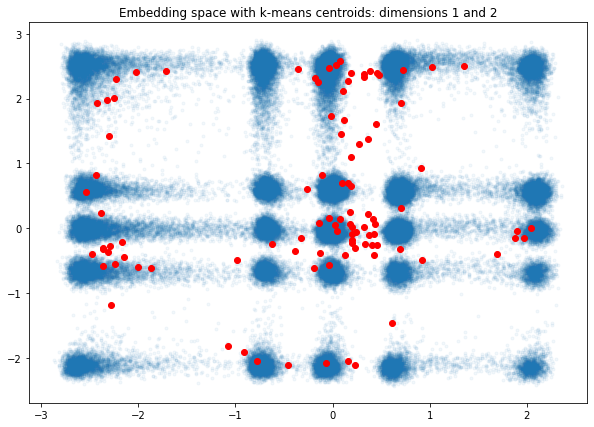

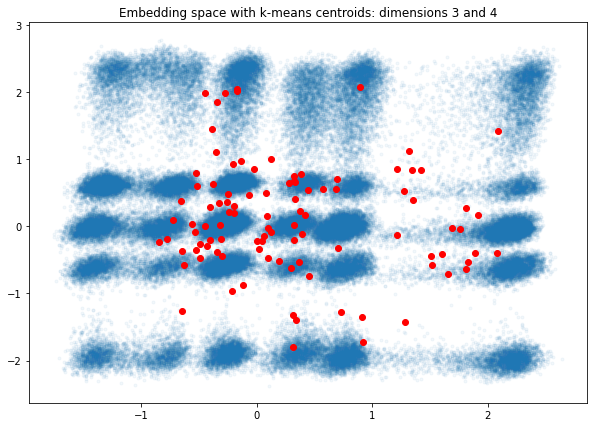

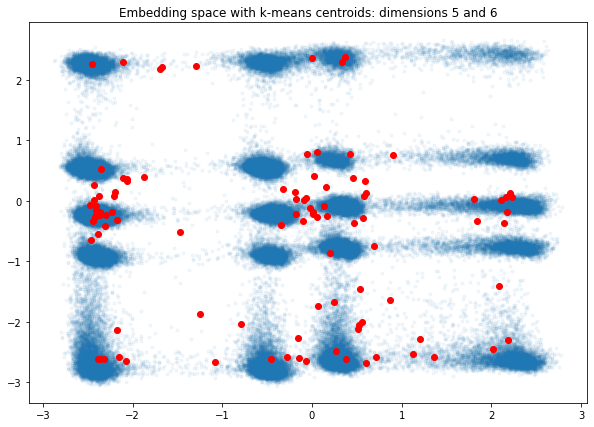

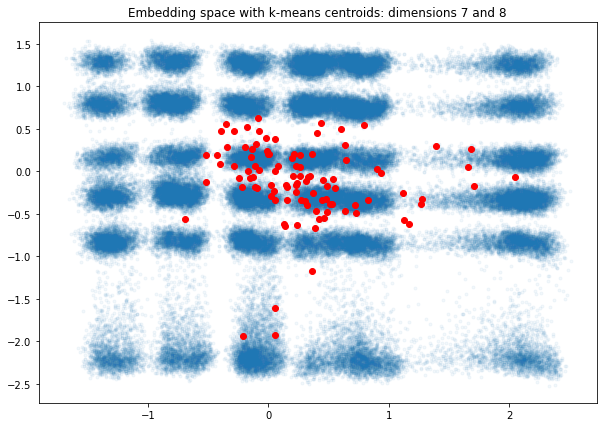

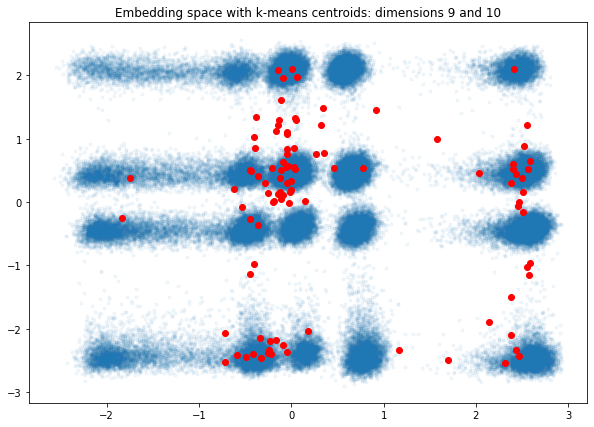

In [217]:
plt.figure(figsize=(10,7))
plt.scatter(unique_emb_vects[:,0], unique_emb_vects[:,1], marker='.', alpha=0.05)
plt.scatter(codebook[:,0],codebook[:,1],color='r')
plt.title('Embedding space with k-means centroids: dimensions 1 and 2')
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(unique_emb_vects[:,2], unique_emb_vects[:,3], marker='.', alpha=0.05)
plt.scatter(codebook[:,2],codebook[:,3],color='r')
plt.title('Embedding space with k-means centroids: dimensions 3 and 4')
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(unique_emb_vects[:,4], unique_emb_vects[:,5], marker='.', alpha=0.05)
plt.scatter(codebook[:,4],codebook[:,5],color='r')
plt.title('Embedding space with k-means centroids: dimensions 5 and 6')
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(unique_emb_vects[:,6], unique_emb_vects[:,7], marker='.', alpha=0.05)
plt.scatter(codebook[:,6],codebook[:,7],color='r')
plt.title('Embedding space with k-means centroids: dimensions 7 and 8')
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(unique_emb_vects[:,8], unique_emb_vects[:,9], marker='.', alpha=0.05)
plt.scatter(codebook[:,8],codebook[:,9],color='r')
plt.title('Embedding space with k-means centroids: dimensions 9 and 10')
plt.show()

**2) Using our 100 centroids want to use our embedding data to create sequences of integers 1-100 based on the closest centroid at a given time. The centroids represent the state between which we're transitioning.**

In [223]:
embedded_spikes.shape

torch.Size([487, 10, 2001])

In [225]:
codebook[0]

array([ 0.4479893 ,  1.6109481 ,  1.4259537 ,  0.84094226,  0.36981687,
        2.3728168 ,  0.05164207, -0.33843893, -0.39435312,  0.85142195],
      dtype=float32)

*For quick nearest-vector lookup going to use KDTree from scipy*

In [226]:
from scipy import spatial
# we define a tree with our array of vectors...
A = [[0,1,2,3,4], [4,3,2,1,0], [2,5,3,7,1], [1,0,1,0,1]]
example_tree = spatial.KDTree(A)

In [227]:
# ... and we can query the tree with a new vector and get
# the index of, and its distance from, the closest vector in the tree
example_tree.query([0.5,0.5,0.5,0.5,0.5])

(1.118033988749895, 3)

**2a) Create our `(trial, sequence len., state number)` state sequence data**

In [230]:
# want to put the vectors on the outside for easier indexing
embedded_sequences = embedded_spikes.permute(0,2,1)
print(embedded_sequences.shape)

torch.Size([487, 2001, 10])


In [232]:
# define our tree of centroids
centroid_tree = spatial.KDTree(codebook)

In [238]:
# example query to the tree
d,v = centroid_tree.query(embedded_sequences[0,0])
print('Input vector:\n',str(embedded_sequences[0,0]))
print('Closest centroid:\n',str(codebook[v]))
print('KDtree-reported distance:',str(d))
print('Euclidean distance:',distance.euclidean(embedded_sequences[0,0], codebook[v]))
print(v)

Input vector:
 tensor([ 0.5068,  2.6621,  1.0025,  2.4233,  2.4491, -2.7423,  1.9848, -0.7884,
        -0.4763, -2.5996])
Closest centroid:
 [ 0.9245144  -0.4895232  -0.16904081  2.0096495   2.0810828  -1.411749
 -0.07947966  0.0140253  -0.399338   -0.98176837]
KDtree-reported distance: 4.591858639575205
Euclidean distance: 4.591858863830566
7


In [247]:
# create our state sequences data set
state_sequences = np.zeros((embedded_sequences.shape[0], embedded_sequences.shape[1]), dtype=int)
print(state_sequences.shape)

(487, 2001)


In [248]:
# loop through our embedded sequence data and populate our state sequence data
for trial in range(embedded_sequences.shape[0]):
    for t in range(embedded_sequences.shape[1]):
        _,v = centroid_tree.query(embedded_sequences[trial,t])
        state_sequences[trial,t] = int(v)

In [249]:
state_sequences

array([[ 7, 25, 57, ..., 17, 27, 96],
       [81, 25, 25, ..., 27, 17, 25],
       [25, 25, 19, ..., 17, 25, 57],
       ...,
       [80, 55, 39, ..., 76, 25, 74],
       [ 7, 35, 54, ..., 25,  1, 39],
       [81, 27, 25, ..., 17, 19, 25]])

In [250]:
print(min(state_sequences.flatten()))
print(max(state_sequences.flatten()))

0
99


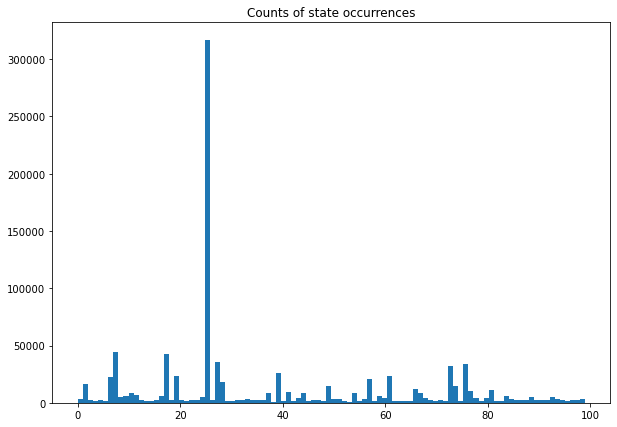

In [264]:
plt.figure(figsize=(10,7))
plt.hist(state_sequences.flatten(), bins=100)
plt.title('Counts of state occurrences')
plt.show()

**3) Create our 100x100 transition matrix**

In [251]:
transition_probabilities = np.zeros((100,100))

In [252]:
# loop through our state sequences data (trial by trial) and fill in the transitions in our matrix
# (first we get the counts and then we divide to convert these probabilities)
for trial in range(state_sequences.shape[0]):
    for t in range(state_sequences.shape[1]-1):
        src = state_sequences[trial, t]
        trg = state_sequences[trial, t+1]
        transition_probabilities[src, trg] += 1

In [255]:
print(transition_probabilities)
print(min(transition_probabilities.flatten()))
print(max(transition_probabilities.flatten()))

[[  9.  64.   7. ...   8.   8.  10.]
 [ 49. 208.  32. ...  45.  37.  46.]
 [  5.  34.   2. ...   7.   8.   8.]
 ...
 [  6.  37.   2. ...   5.   8.   6.]
 [  9.  34.   8. ...   7.   4.   7.]
 [  5.  38.   5. ...   7.   4.  12.]]
0.0
110101.0


In [256]:
# ... and then we normalize each row by the count in that row
for i in range(100):
    tot = sum(transition_probabilities[i])
    probs = transition_probabilities[i]/tot
    transition_probabilities[i] = probs

In [265]:
print(np.argmin(transition_probabilities.flatten()))
print(np.argmax(transition_probabilities.flatten()))

248
2525


*From the fact that the greatest transition probability is going INTO state 25, we imagine state 25 is the state corresponding to the zero vector. Let's double check this by feeding the zero vector through our embedding and finding the closest centroid:*

In [281]:
zero_vect = torch.from_numpy(np.zeros(131)).float()
with torch.no_grad():
    zero_emb = encoder(zero_vect)
print(centroid_tree.query(zero_emb)) #<- we get 25 as the closest state

(6.629940925989926, 25)


*... and we can also see what the related probabilities to the zero state look like:*

In [267]:
print(transition_probabilities[25,25])
print(transition_probabilities[:,25])

0.3483216805340251
[0.30800701 0.30119822 0.30083955 0.26900585 0.31601183 0.27552987
 0.32431343 0.34017661 0.30923046 0.30500088 0.30888076 0.31059908
 0.2865621  0.26156693 0.28139382 0.28438315 0.32758323 0.33425137
 0.30187793 0.32059356 0.3001053  0.28976035 0.28853383 0.31155779
 0.3065792  0.34832168 0.29493088 0.31802735 0.32048328 0.27751756
 0.28513825 0.30813674 0.30607735 0.32184268 0.2896007  0.31202435
 0.30727894 0.32512784 0.28639391 0.31236682 0.29689067 0.29236461
 0.29276896 0.29172858 0.31698113 0.27675528 0.30590263 0.29109589
 0.27378049 0.30553993 0.31112939 0.30082418 0.25113858 0.27657658
 0.30075612 0.27721943 0.29984544 0.33910617 0.27894089 0.32455395
 0.29733039 0.30309584 0.29238039 0.28976697 0.26022013 0.28302872
 0.30290525 0.32841504 0.28102462 0.31974249 0.28488372 0.29158435
 0.2854466  0.31697387 0.30950611 0.2757764  0.32662792 0.33908582
 0.29138454 0.2900641  0.31353919 0.29422819 0.2790493  0.29357798
 0.28711847 0.28582974 0.29404415 0.2841213

***getting the eigenspectrum of the transition matrix***

In [270]:
eigenvals, eigenvects = np.linalg.eig(transition_probabilities.T)

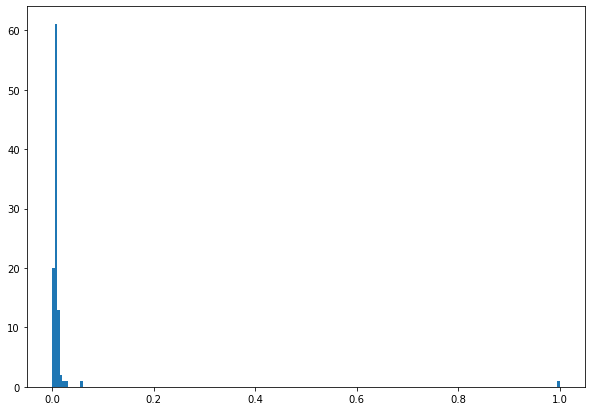

In [278]:
eval_mags = [np.abs(v) for v in eigenvals]
plt.figure(figsize=(10,7))
plt.hist(eval_mags,bins=200)
plt.show()

*From the magnitude of these eigenvalues is looks like things shoot back to the steady state very very quickly – this seems like the system doesn't have any significant dynamics.*

**4) Want to wrap this all in a function so we can easily generate a k-means transition matrix from any set of data**

In [22]:
def create_kmeans_transition_mtx(data, k, kmeans_iter=100, use_unique_vectors=True):
    '''
    Function to take in a set of data and create transition matrices
    based on states given by the centroids found through a k-means clustering
    process for a given value of k.
    
    We have a flag the will dictate whether the input data is given to kmeans as
    is, or if we just feed it the set of unique vectors (this being the choice
    of whether to make the states frequency-agnostic or not).
    
    We assume the data is given to this function in the form (trials, data dim, seq. len.)
    
    Return: both the transition counts and transition probabilities
    '''
    # reshaping the data
    embedded_sequences = np.transpose(data, (0,2,1))
    embedded_vects = np.array(np.reshape(embedded_sequences,\
                                         (embedded_sequences.shape[0]*embedded_sequences.shape[1],\
                                          embedded_sequences.shape[2])))
    
    # getting rid of duplicates if we have the unique flag turned to True
    if use_unique_vectors:
        kmeans_input_vects = np.unique(embedded_vects,axis=0)
    else:
        kmeans_input_vects = embedded_vects
        
    # apply the kmeans clustering , getting the codebook of centroids   
    codebook, _ = kmeans(kmeans_input_vects, k, iter=kmeans_iter)
    
    # define our KDTree for quick distance calculation WRT the centroids
    centroid_tree = spatial.KDTree(codebook)
    
    # create our state sequences data set
    state_sequences = np.zeros((embedded_sequences.shape[0], embedded_sequences.shape[1]), dtype=int)

    
    # loop through our embedded sequence data and populate our state sequence data
    for trial in range(embedded_sequences.shape[0]):
        for t in range(embedded_sequences.shape[1]):
            _,v = centroid_tree.query(embedded_sequences[trial,t])
            state_sequences[trial,t] = int(v)
            
    # create our matrices for transition counts and transition probabilities
    transition_counts = np.zeros((100,100))
    transition_probabilities = np.zeros((100,100))
    
    # loop through our state sequences data (trial by trial) and fill in the transitions in our matrix
    # (first we get the counts and then we divide to convert these probabilities)
    for trial in range(state_sequences.shape[0]):
        for t in range(state_sequences.shape[1]-1):
            src = state_sequences[trial, t]
            trg = state_sequences[trial, t+1]
            transition_counts[src, trg] += 1
            
    # ... and then we normalize each row by the count in that row and populate our probabilities matrix
    for i in range(100):
        tot = sum(transition_counts[i])
        probs = transition_counts[i]/tot
        transition_probabilities[i] = probs
        
    return transition_probabilities, transition_counts, state_sequences

***The maximum value in the transition matrix is 0.35; that doesn't bode well for this system being deterministic***

----

*Let's check that we get the same results with this function*

In [69]:
empirical_transition_probs, empirical_transition_counts, state_sequences = create_kmeans_transition_mtx(embedded_spikes, k=100)

In [70]:
print(min(empirical_transition_probs.flatten()))
print(max(empirical_transition_probs.flatten()))

0.0
0.3372177615367853


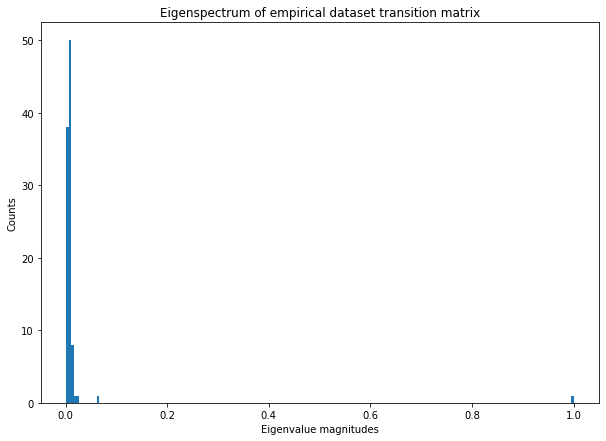

In [73]:
evals, evects = np.linalg.eig(empirical_transition_probs.T)
eval_mags = [np.abs(v) for v in evals]
plt.figure(figsize=(10,7))
plt.hist(eval_mags,bins=200)
plt.xlabel('Eigenvalue magnitudes')
plt.ylabel('Counts')
plt.title('Eigenspectrum of empirical dataset transition matrix')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_data_eigenspectrum', dpi=300)
plt.show()

Lastly, we can calculate the average log likelihood of our data under the Markov distribution and under the memoryless distribution:

$$\frac{1}{T}\sum\log_2\left(\frac{p(q_t|q_{t-1})}{p(q_t)}\right)$$

... to give us a measure of the average number of bits per state of extra information we get from our Markov distribution compared to the naive memoryless distribution (or, a measure of the extra information that is provided by accounting for the previous state)

In [29]:
def get_log_likelihood(sequence_data, transition_probs, transition_counts):
    '''
    Function to calculate the log likelihood between a markov state transition
    distribution (given by the trans. probs. matrix) and the memoryless distribution
    (which we'll calculate from our transition count matrix).
    
    The sum is taken over our composite sequence taken by lying each trial back to back (not
    counting the end of one trial to the beginning of the next as a transition)
    '''
    memoryless_distribution = []
    # the memoryless probability of state x is the sum of counts
    # in row x divided by the sum of all elements in the matrix
    total_transitions = sum(transition_counts.flatten())
    for x in range(transition_counts.shape[0]):
        x_prob = sum(transition_counts[x])/total_transitions
        memoryless_distribution.append(x_prob)
        
    total_log_likelihood = 0
    for trial in range(sequence_data.shape[0]):
        for t in range(sequence_data.shape[1]-1):
            src = sequence_data[trial, t]
            trg = sequence_data[trial, t+1]
            markov_prob = transition_probs[src,trg]
            memless_prob = memoryless_distribution[trg]
            total_log_likelihood += np.log2(markov_prob/memless_prob)
            
    return (1/(sequence_data.shape[0]*sequence_data.shape[1])) * total_log_likelihood

In [322]:
get_log_likelihood(state_sequences, empirical_transition_probs, empirical_transition_counts)

0.011788105933294692

*It looks like we get very little extra information from considering our previous state*

---

# Running the same analyses on our two synthetic datasets

To give context for the results we found with our RNN models, we created two synthetic datasets – one explicitly *with* inter-channel dynamics and one explicitly *without* them – that we also ran through our models. To go along with the model result we got with the two synthetic datasets, we will also perform the latent space analysis on those two datasets to look at the eigenspectra of their transition matrices.

## (Sorted) Dynamical dataset

We constructed two dynamical datasets: in one the units' firing rate functions were peaked at random times uniformly distributed around the circle (of revolution time equal to the average interspike time), and in the other the firing rates were ordered such that channel $i$ peaked before channel $i+1$ and so on.

The sorting step makes the inter-channel dynamics easier to visualize but the data is equivalent in both cases once it is being processed by the network (the network has no way of taking channel order into account).

In [15]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_spike_mtx__16_48_50.npy', 'rb') as f:
    dynamic_spikes = np.load(f, allow_pickle=True)

In [16]:
dynamic_spikes.shape

(487, 131, 2001)

**1) Train the Phase 1 autoencoder**

In [17]:
dp = '../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_spike_mtx__16_48_50.npy'
m = 10
w = 100
tau = 0
epochs = 5

model, output = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)

[1,  1000] loss: 0.225
[1,  2000] loss: 0.090
[1,  3000] loss: 0.073
[1,  4000] loss: 0.064
[1,  5000] loss: 0.057
[1,  6000] loss: 0.054
[1,  7000] loss: 0.050
[1,  8000] loss: 0.047
[1,  9000] loss: 0.042
[2,  1000] loss: 0.039
[2,  2000] loss: 0.037
[2,  3000] loss: 0.036
[2,  4000] loss: 0.033
[2,  5000] loss: 0.034
[2,  6000] loss: 0.032
[2,  7000] loss: 0.031
[2,  8000] loss: 0.031
[2,  9000] loss: 0.030
[3,  1000] loss: 0.028
[3,  2000] loss: 0.027
[3,  3000] loss: 0.028
[3,  4000] loss: 0.027
[3,  5000] loss: 0.026
[3,  6000] loss: 0.027
[3,  7000] loss: 0.024
[3,  8000] loss: 0.027
[3,  9000] loss: 0.024
[4,  1000] loss: 0.023
[4,  2000] loss: 0.025
[4,  3000] loss: 0.023
[4,  4000] loss: 0.024
[4,  5000] loss: 0.023
[4,  6000] loss: 0.023
[4,  7000] loss: 0.024
[4,  8000] loss: 0.022
[4,  9000] loss: 0.024
[5,  1000] loss: 0.021
[5,  2000] loss: 0.021
[5,  3000] loss: 0.023
[5,  4000] loss: 0.023
[5,  5000] loss: 0.021
[5,  6000] loss: 0.022
[5,  7000] loss: 0.021
[5,  8000] 

1a) Calculate model performance

In [18]:
from experiments import calculate_avg_pred_prob

nospike_pred_prob, spike_pred_prob = calculate_avg_pred_prob(model, torch.from_numpy(dynamic_spikes).float(), tau)
print('model avg. probability for no input spike',str(nospike_pred_prob),str(type(nospike_pred_prob)))
print('model avg. probability for input spike',str(spike_pred_prob),str(type(spike_pred_prob)))

model avg. probability for no input spike 0.015709280967712402 <class 'float'>
model avg. probability for input spike 0.9913195371627808 <class 'float'>


In [43]:
encoder = model.encoder

**2) Get embedded dataset and create the kmeans transition matrix**

In [20]:
input_dynamic_spikes, embedded_dynamic_spikes = get_embedded_dataset(dynamic_spikes, encoder, M=10, tau=0)

In [24]:
from scipy import spatial
from scipy.cluster.vq import vq, kmeans

dynamical_transition_probs, dynamical_transition_counts, state_sequences = \
    create_kmeans_transition_mtx(embedded_dynamic_spikes, k=100)

In [26]:
max(dynamical_transition_probs.flatten())

0.5623948873192062

**3) Plot eigenspectrum**

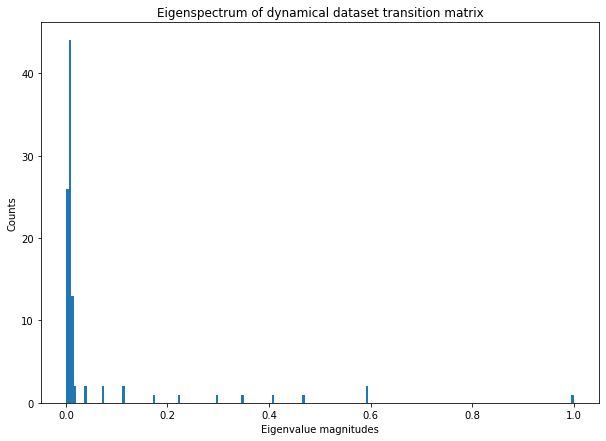

In [45]:
evals, evects = np.linalg.eig(dynamical_transition_probs.T)
eval_mags = [np.abs(v) for v in evals]
plt.figure(figsize=(10,7))
plt.hist(eval_mags,bins=200)
plt.xlabel('Eigenvalue magnitudes')
plt.ylabel('Counts')
plt.title('Eigenspectrum of dynamical dataset transition matrix')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dyn_data_s5_eigenspectrum', dpi=300)
plt.show()

*We see a lot more positive-magnitude eigenvalues which represent cycles in the transition matrix*

**4) Get our rough measure of extra information given by accounting for the previous state**

In [30]:
get_log_likelihood(state_sequences, dynamical_transition_probs, dynamical_transition_counts)

0.6912778612409679

*Approximately 0.691 extra bits of information – much larger than the 0.012 we got from the empirical embedded data*

### ... and also with the $\sigma = 20$ dynamical dataset:

In [47]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_sigma20_spike_mtx__09_08_40.npy', 'rb') as f:
    dynamic_spikes = np.load(f, allow_pickle=True)

In [48]:
dynamic_spikes.shape

(487, 131, 2001)

**1) Train the Phase 1 autoencoder**

In [49]:
dp = '../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_sigma20_spike_mtx__09_08_40.npy'
m = 10
w = 100
tau = 0
epochs = 5

model, output = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)

[1,  1000] loss: 0.314
[1,  2000] loss: 0.165
[1,  3000] loss: 0.137
[1,  4000] loss: 0.112
[1,  5000] loss: 0.094
[1,  6000] loss: 0.081
[1,  7000] loss: 0.074
[1,  8000] loss: 0.068
[1,  9000] loss: 0.063
[2,  1000] loss: 0.056
[2,  2000] loss: 0.056
[2,  3000] loss: 0.053
[2,  4000] loss: 0.051
[2,  5000] loss: 0.048
[2,  6000] loss: 0.047
[2,  7000] loss: 0.045
[2,  8000] loss: 0.045
[2,  9000] loss: 0.043
[3,  1000] loss: 0.041
[3,  2000] loss: 0.040
[3,  3000] loss: 0.038
[3,  4000] loss: 0.038
[3,  5000] loss: 0.037
[3,  6000] loss: 0.036
[3,  7000] loss: 0.036
[3,  8000] loss: 0.034
[3,  9000] loss: 0.033
[4,  1000] loss: 0.030
[4,  2000] loss: 0.032
[4,  3000] loss: 0.030
[4,  4000] loss: 0.029
[4,  5000] loss: 0.030
[4,  6000] loss: 0.029
[4,  7000] loss: 0.029
[4,  8000] loss: 0.026
[4,  9000] loss: 0.027
[5,  1000] loss: 0.026
[5,  2000] loss: 0.027
[5,  3000] loss: 0.025
[5,  4000] loss: 0.025
[5,  5000] loss: 0.025
[5,  6000] loss: 0.024
[5,  7000] loss: 0.025
[5,  8000] 

1a) Calculate model performance

In [50]:
from experiments import calculate_avg_pred_prob

nospike_pred_prob, spike_pred_prob = calculate_avg_pred_prob(model, torch.from_numpy(dynamic_spikes).float(), tau)
print('model avg. probability for no input spike',str(nospike_pred_prob),str(type(nospike_pred_prob)))
print('model avg. probability for input spike',str(spike_pred_prob),str(type(spike_pred_prob)))

model avg. probability for no input spike 0.015209972858428955 <class 'float'>
model avg. probability for input spike 0.9897632598876953 <class 'float'>


In [51]:
encoder = model.encoder

**2) Get embedded dataset and create the kmeans transition matrix**

In [52]:
input_dynamic_spikes, embedded_dynamic_spikes = get_embedded_dataset(dynamic_spikes, encoder, M=10, tau=0)

In [53]:
from scipy import spatial
from scipy.cluster.vq import vq, kmeans

dynamical_transition_probs, dynamical_transition_counts, state_sequences = \
    create_kmeans_transition_mtx(embedded_dynamic_spikes, k=100)

In [54]:
max(dynamical_transition_probs.flatten())

0.5576320371445154

**3) Plot eigenspectrum**

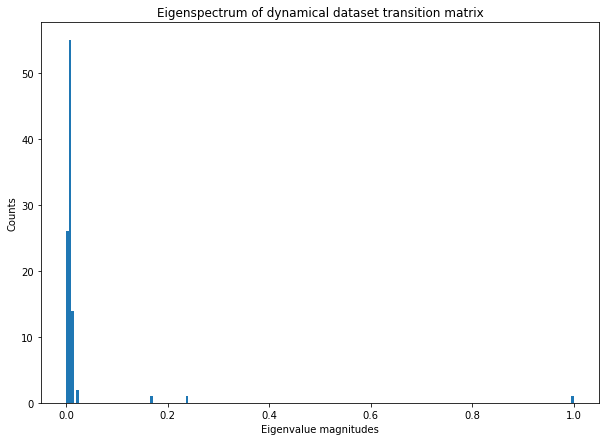

In [57]:
evals, evects = np.linalg.eig(dynamical_transition_probs.T)
eval_mags = [np.abs(v) for v in evals]
plt.figure(figsize=(10,7))
plt.hist(eval_mags,bins=200)
plt.xlabel('Eigenvalue magnitudes')
plt.ylabel('Counts')
plt.title('Eigenspectrum of dynamical dataset transition matrix')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dyn_data_s20_eigenspectrum', dpi=300)
plt.show()

*We see a lot more positive-magnitude eigenvalues which represent cycles in the transition matrix*

**4) Get our rough measure of extra information given by accounting for the previous state**

In [56]:
get_log_likelihood(state_sequences, dynamical_transition_probs, dynamical_transition_counts)

0.07122802985438734

*Approximately 0.691 extra bits of information – much larger than the 0.012 we got from the empirical embedded data*

## Nondynamical dataset

This dataset was simply constructed by iterating through the recording channels in our empirical data and changing the placement of each channels' spikes such that the spike times were uniformly distributed over the possible range of times. This mainted the data's statistics regarding number and average frequency of spikes, but ensured that each channel was an independent Poisson process.

In [31]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_NONDYN_spike_mtx__11_32_10.npy', 'rb') as f:
    nondynamic_spikes = np.load(f, allow_pickle=True)

In [32]:
nondynamic_spikes.shape

(487, 131, 2001)

**1) Train the Phase 1 autoencoder**

In [33]:
dp = '../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_NONDYN_spike_mtx__11_32_10.npy'
m = 10
w = 100
tau = 0
epochs = 5

nondyn_model, nondyn_output = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)

[1,  1000] loss: 0.419
[1,  2000] loss: 0.211
[1,  3000] loss: 0.161
[1,  4000] loss: 0.138
[1,  5000] loss: 0.119
[1,  6000] loss: 0.105
[1,  7000] loss: 0.092
[1,  8000] loss: 0.085
[1,  9000] loss: 0.078
[2,  1000] loss: 0.068
[2,  2000] loss: 0.062
[2,  3000] loss: 0.061
[2,  4000] loss: 0.057
[2,  5000] loss: 0.053
[2,  6000] loss: 0.051
[2,  7000] loss: 0.050
[2,  8000] loss: 0.049
[2,  9000] loss: 0.047
[3,  1000] loss: 0.045
[3,  2000] loss: 0.044
[3,  3000] loss: 0.045
[3,  4000] loss: 0.042
[3,  5000] loss: 0.042
[3,  6000] loss: 0.043
[3,  7000] loss: 0.042
[3,  8000] loss: 0.041
[3,  9000] loss: 0.043
[4,  1000] loss: 0.040
[4,  2000] loss: 0.042
[4,  3000] loss: 0.039
[4,  4000] loss: 0.040
[4,  5000] loss: 0.041
[4,  6000] loss: 0.038
[4,  7000] loss: 0.038
[4,  8000] loss: 0.039
[4,  9000] loss: 0.039
[5,  1000] loss: 0.037
[5,  2000] loss: 0.038
[5,  3000] loss: 0.039
[5,  4000] loss: 0.035
[5,  5000] loss: 0.038
[5,  6000] loss: 0.038
[5,  7000] loss: 0.036
[5,  8000] 

1a) Calculate model performance

In [34]:
from experiments import calculate_avg_pred_prob

nospike_pred_prob, spike_pred_prob = calculate_avg_pred_prob(nondyn_model, torch.from_numpy(nondynamic_spikes).float(), tau)
print('model avg. probability for no input spike',str(nospike_pred_prob),str(type(nospike_pred_prob)))
print('model avg. probability for input spike',str(spike_pred_prob),str(type(spike_pred_prob)))

model avg. probability for no input spike 0.02905493974685669 <class 'float'>
model avg. probability for input spike 0.9906342029571533 <class 'float'>


In [35]:
nondyn_encoder = nondyn_model.encoder

**2) Get embedded dataset and create the kmeans transition matrix**

In [36]:
input_nondynamic_spikes, embedded_nondynamic_spikes = get_embedded_dataset(nondynamic_spikes, nondyn_encoder, M=10, tau=0)

In [37]:
from scipy import spatial
from scipy.cluster.vq import vq, kmeans

nondynamical_transition_probs, nondynamical_transition_counts, nondyn_state_sequences = \
    create_kmeans_transition_mtx(embedded_nondynamic_spikes, k=100)

In [38]:
max(nondynamical_transition_probs.flatten())

0.3362031855359449

**3) Plot eigenspectrum**

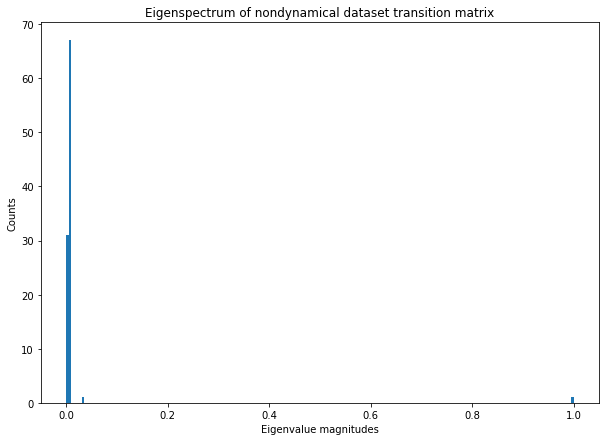

In [46]:
evals, evects = np.linalg.eig(nondynamical_transition_probs.T)
eval_mags = [np.abs(v) for v in evals]
plt.figure(figsize=(10,7))
plt.hist(eval_mags,bins=200)
plt.xlabel('Eigenvalue magnitudes')
plt.ylabel('Counts')
plt.title('Eigenspectrum of nondynamical dataset transition matrix')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondyn_data_eigenspectrum', dpi=300)
plt.show()

**4) Get our rough measure of extra information given by accounting for the previous state**

In [41]:
get_log_likelihood(nondyn_state_sequences, nondynamical_transition_probs, nondynamical_transition_counts)

0.008233578772594069

Very similar eigenspectrum, log-likelihood ratio, and max transition probability to our empirical data